## Import Library and Load Data

In [ ]:
from operator import imod
#Import Library
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import kagglehub


## Check the size of the images



Kiểm tra size của ảnh, nếu cùng sie thì giữ nguyên, khác size thì phải resize lại.

In [ ]:
# Ktra kich thuoc cua anh,
# Load data
base_path = kagglehub.dataset_download("mostafaabla/garbage-classification")
dimensions = set()
for category in os.listdir(base_path):
    category_path = os.path.join(base_path, category)
    if not os.path.isdir(category_path):
      continue

    for img_name in os.listdir(category_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                dimensions.add((*img.size, len(img.getbands())))
if len(dimensions) == 1:
  width, height, chanels = list(dimensions)[0]
  print(f'Anh co 1 size:, {width} x {height}, so kenh mau: {chanels}')
else:
  print(f'Anh co nhieu kich thuoc: {len(dimensions)}')

100%|██████████| 239M/239M [00:11<00:00, 21.5MB/s]

Extracting files...


Anh co nhieu kich thuoc: 0


In [ ]:
import os

path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("Dataset path:", path)

# In ra 2 cấp đầu để xem thật ra ảnh nằm ở đâu
for root, dirs, files in os.walk(path):
    print(root)
    print("Dirs:", dirs)
    print("Files:", files[:5])
    break


Dataset path: /root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1
/root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1
Dirs: ['garbage_classification']
Files: []


## Create DataFrame

In [ ]:
dataset_path = os.path.join(path, "garbage_classification")
data = []
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder):
        for file_name in os.listdir(class_folder):
            # Chỉ lấy file ảnh
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_folder, file_name)
                data.append([file_path, class_name])

df = pd.DataFrame(data, columns=["file_path", "label"])
print(f'Do dai cua Df: {len(df)}')
print("So class:", df['label'].nunique())
print(df.head())


Do dai cua Df: 15515
So class: 12
                                           file_path    label
0  /root/.cache/kagglehub/datasets/mostafaabla/ga...  plastic
1  /root/.cache/kagglehub/datasets/mostafaabla/ga...  plastic
2  /root/.cache/kagglehub/datasets/mostafaabla/ga...  plastic
3  /root/.cache/kagglehub/datasets/mostafaabla/ga...  plastic
4  /root/.cache/kagglehub/datasets/mostafaabla/ga...  plastic


## Split Train and Test

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['label'], random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
print("Classes:", df['label'].nunique())


Train size: 12412
Validation size: 1551
Test size: 1552
Classes: 12


## Data augmentation and preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Constants ---
BATCH_SIZE = 32
NUM_CLASSES = 12
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 320
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

# --- Data augmentation cho train ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# --- Validation và Test chỉ rescale, không augment ---
test_val_datagen = ImageDataGenerator(rescale=1./255)

# --- Train generator ---
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# --- Validation generator ---
valid_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# --- Test generator ---
test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 12412 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.


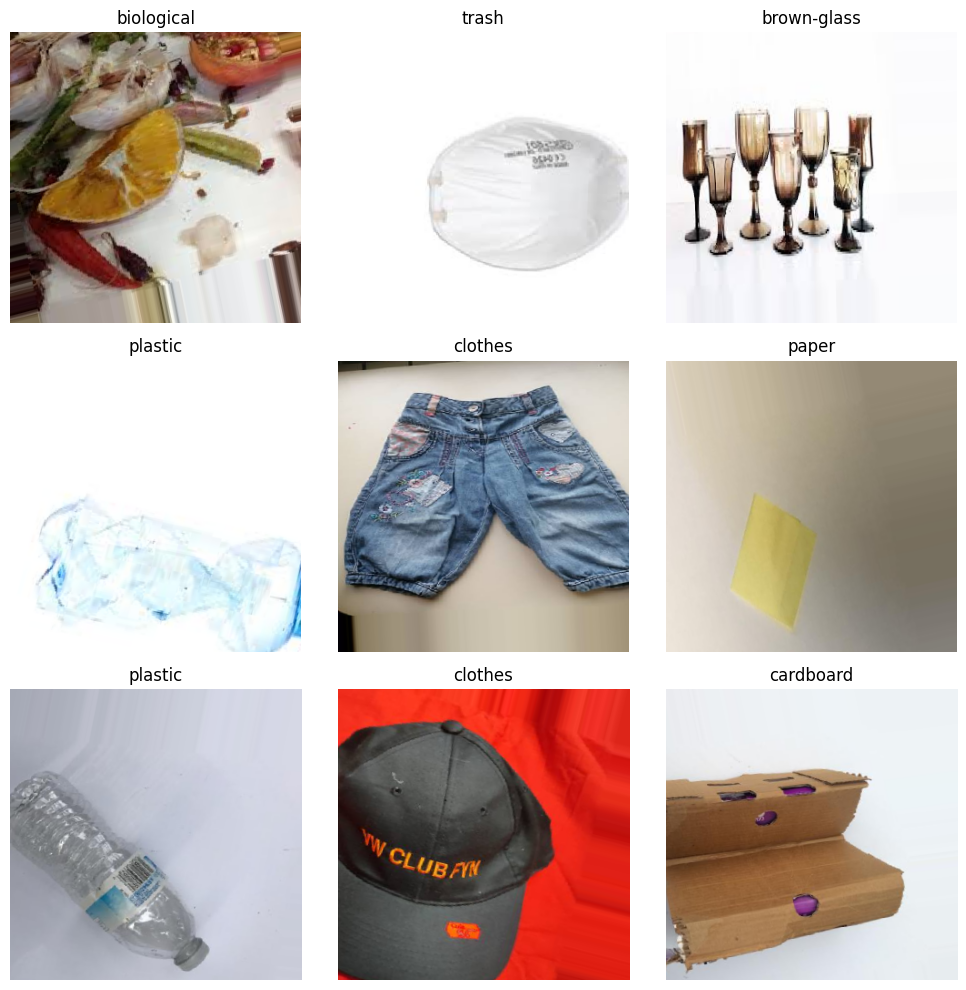

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy một batch ảnh và nhãn
images, labels = next(train_generator)

# Lấy tên lớp theo thứ tự index
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx], fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Build model with transfer learning

In [ ]:

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

IMG_SIZE = 320

# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

# Model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(12, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))


# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    callbacks=[early_stop])

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(train_generator,
                             validation_data=valid_generator,
                             epochs=5,
                             callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f" Test accuracy: {test_acc:.4f}")


/tmp/ipython-input-2883161648.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 370s 900ms/step - accuracy: 0.7275 - loss: 0.9009 - val_accuracy: 0.9142 - val_loss: 0.2852
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 293s 754ms/step - accuracy: 0.8880 - loss: 0.3548 - val_accuracy: 0.9220 - val_loss: 0.2518
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 292s 753ms/step - accuracy: 0.9075 - loss: 0.2840 - val_accuracy: 0.9194 - val_loss: 0.2436
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 292s 753ms/step - accuracy: 0.9122 - loss: 0.2705 - val_accuracy: 0.9259 - val_loss: 0.2229
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 313s 807ms/step - accuracy: 0.9210 - loss: 0.2386 - val_accuracy: 0.9246 - val_loss: 0.2214
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 297s 765ms/step - accuracy: 0.9285 - loss: 0.2244 - val_accuracy: 0.9284 - val_loss: 0.2068
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 291s 750ms/step - accuracy: 0.9244 - loss: 0.2127 - val_accuracy: 0.9355 - val_loss: 0.1970
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 295s 760ms/step - accuracy: 0.9275 -

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)   # classification multi-class
y_true = test_generator.classes            # ground truth

# Evaluate
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Nếu muốn chi tiết theo từng class:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step
Accuracy:  0.9478
Precision: 0.9481
Recall:    0.9478
F1-score:  0.9473

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        95
           1       0.93      0.98      0.96        99
           2       0.87      0.97      0.91        61
           3       0.96      0.92      0.94        89
           4       0.99      0.99      0.99       533
           5       0.92      0.92      0.92        63
           6       0.91      0.78      0.84        77
           7       0.93      0.94      0.93       105
           8       0.88      0.90      0.89        86
           9       0.95      0.97      0.96       198
          10       0.94      0.93      0.93        69
          11       0.93      0.82      0.87        77

    accuracy                           0.95      1552
   macro avg       0.93      0.92      0.93      1552
weighted avg       0.95      0.95      0.95      1

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9414 - loss: 0.1980

Test Accuracy: 0.9478
Test Loss: 0.1738


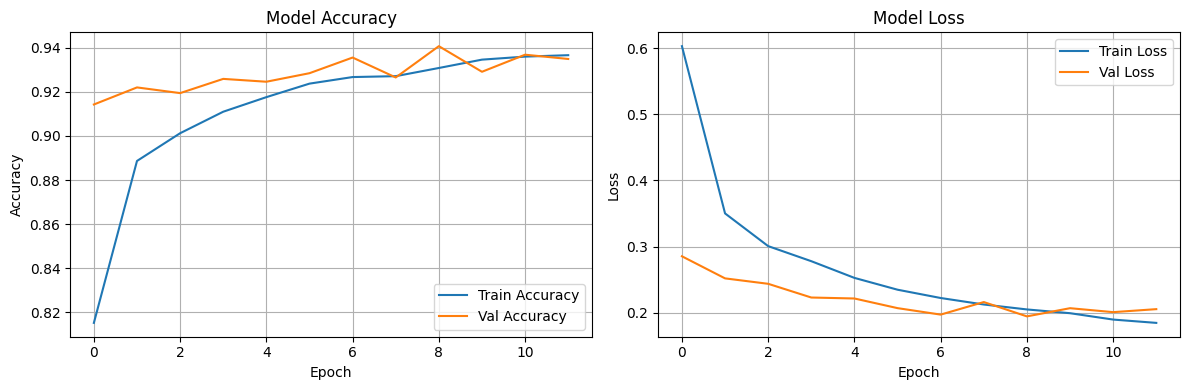

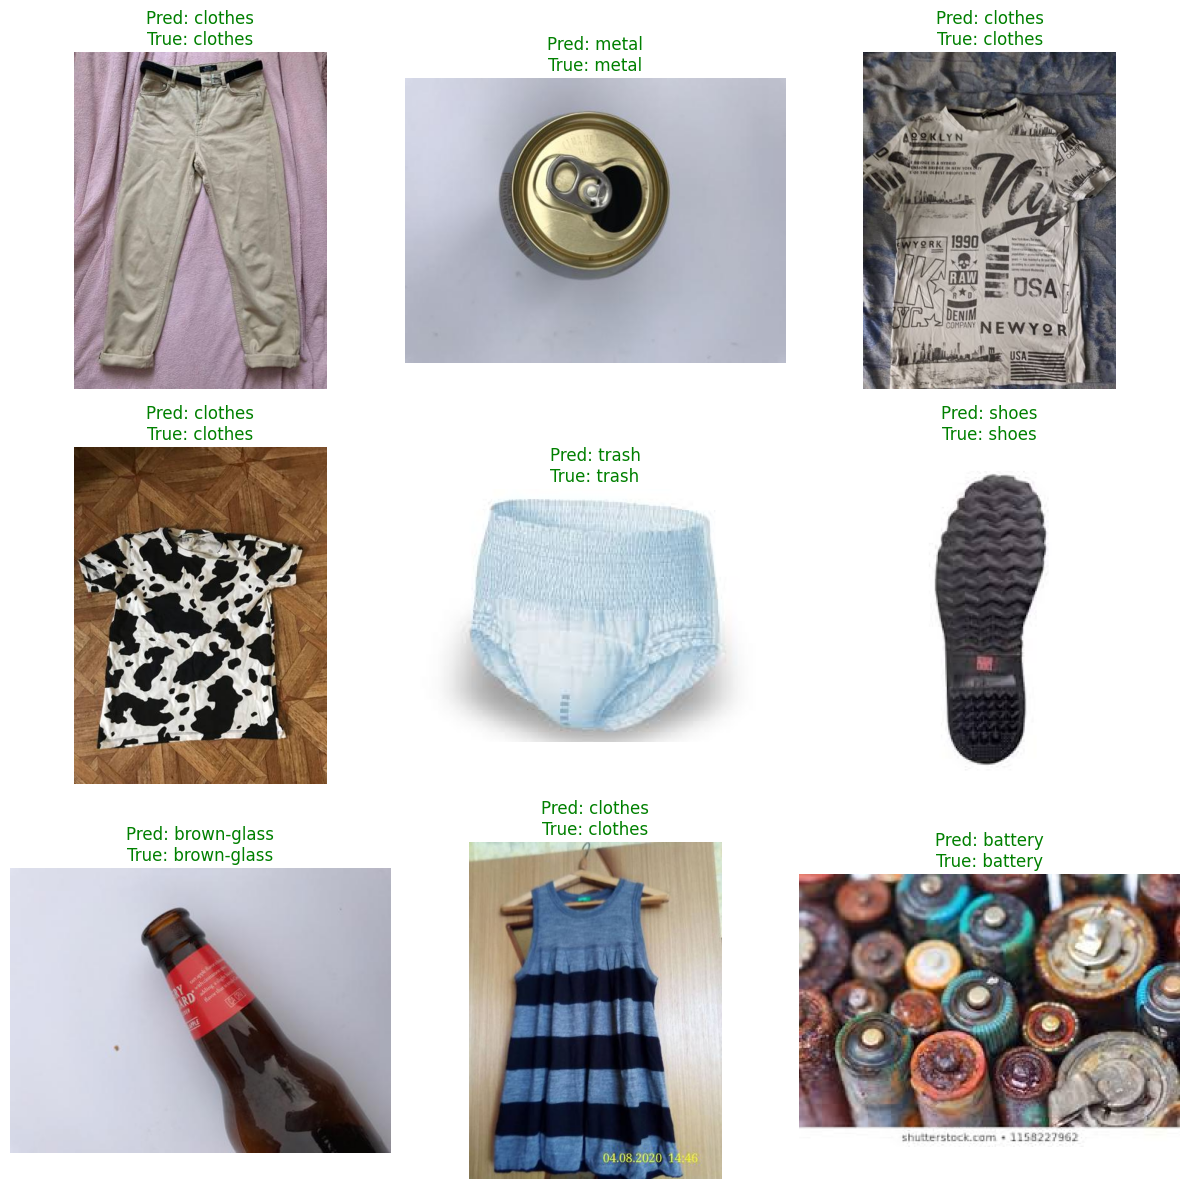

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save final model
model.save('garbage_classification_model.h5')

# -----------------------------
# 🎯 Visualize predictions
# -----------------------------
class_labels = list(test_generator.class_indices.keys())

# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Select random images to visualize
n_samples = 9
indices = random.sample(range(len(test_generator.filenames)), n_samples)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    true_label = class_labels[test_generator.classes[idx]]
    pred_label = class_labels[y_pred[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step
Số ảnh bị dự đoán sai: 81 / 1552


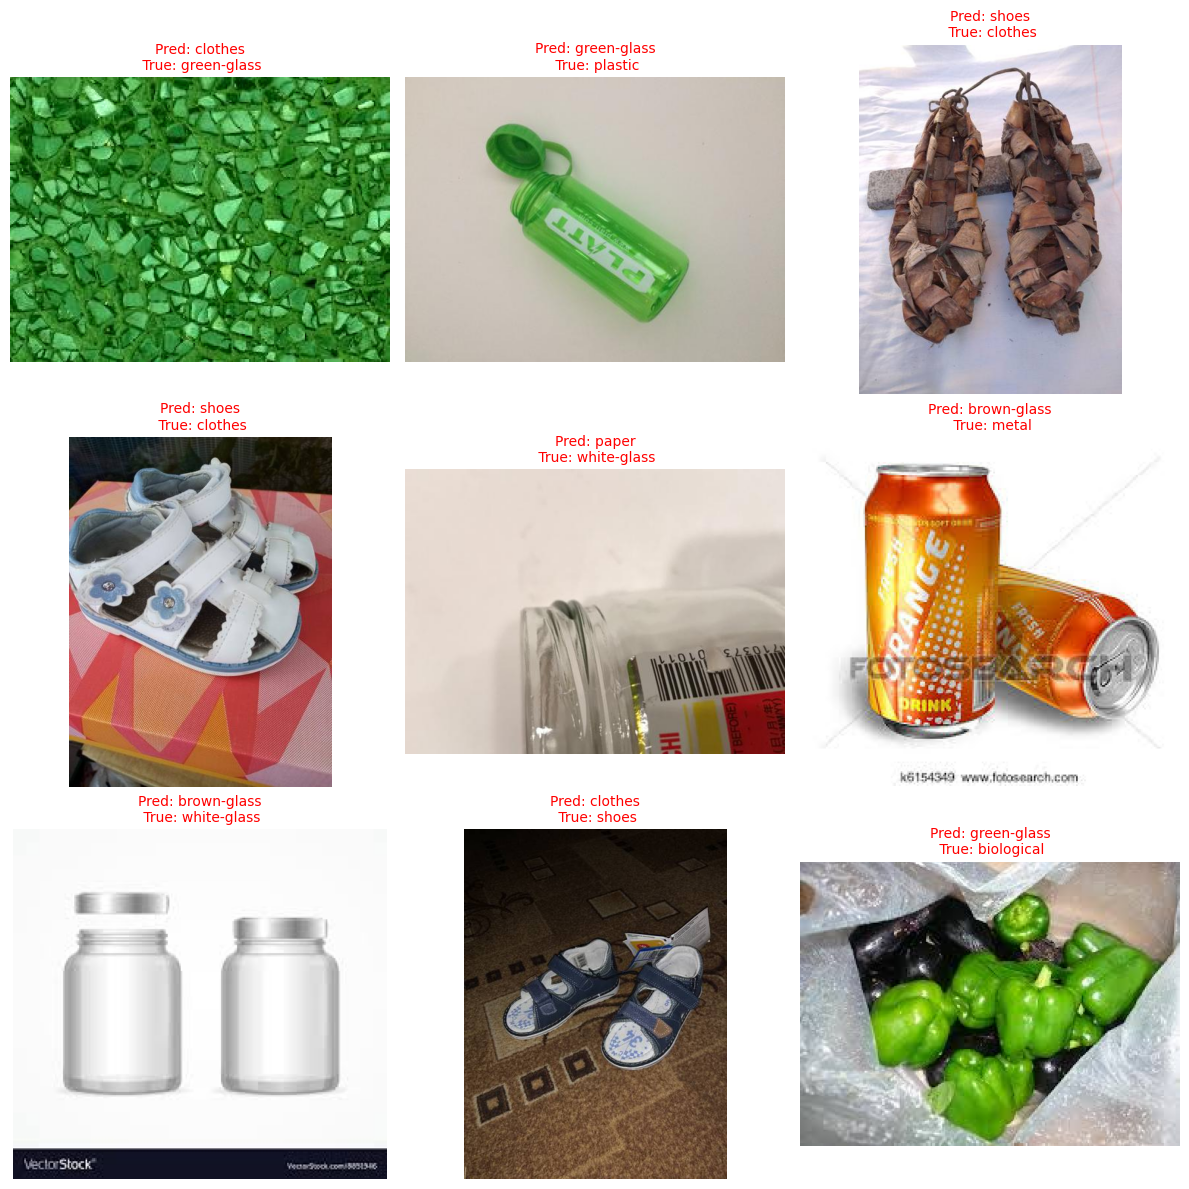

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_indices = {v: k for k, v in test_generator.class_indices.items()}

# Tìm các mẫu dự đoán sai
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Số ảnh bị dự đoán sai: {len(misclassified_indices)} / {len(y_true)}")

# Chọn ngẫu nhiên vài ảnh sai để xem
num_samples = 9
sample_indices = random.sample(list(misclassified_indices), min(num_samples, len(misclassified_indices)))

plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Pred: {class_indices[y_pred[idx]]}\n True: {class_indices[y_true[idx]]}",
        fontsize=10, color="red"
    )
plt.tight_layout()
plt.show()